# Features of a correlation matrix

In [1]:
# export
import numpy as np
import pandas as pd

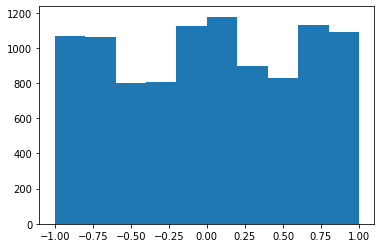

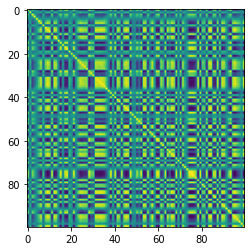

In [2]:
import matplotlib.pyplot as plt

n = 100
a = 2

A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
corr_mtx = D_half*A*D_half
vals = list(np.array(corr_mtx.ravel())[0])
plt.hist(vals, range=(-1,1))
plt.show()
plt.imshow(corr_mtx, interpolation=None)
plt.show()
corr_mtx=np.array(corr_mtx)

In [10]:
l=['coeffs', 'coeffs_min', 'coeffs_max']
query='coeffs_'
sum([s.startswith(query) for s in l]) > 0

True

In [24]:
# export
def compute_features_from_correl(model_corr, features_to_calc=["coeffs_1%",
                                                               "coeffs_10%",
                                                               "coeffs_25%",
                                                               "coeffs_50%",
                                                               "coeffs_75%",
                                                               "coeffs_90%",
                                                               "coeffs_99%",
                                                               "coeffs_max",
                                                               "coeffs_mean",
                                                               "coeffs_min",
                                                               "coeffs_std",
                                                               "condition_number",
                                                               "coph_corr_average",
                                                               "coph_corr_complete",
                                                               "coph_corr_single",
                                                               "coph_corr_ward",
                                                               "determinant",
                                                            #    "mst_avg_shortest",
                                                            #    "mst_centrality_25%",
                                                            #    "mst_centrality_50%",
                                                            #    "mst_centrality_75%",
                                                            #    "mst_centrality_max",
                                                            #    "mst_centrality_mean",
                                                            #    "mst_centrality_min",
                                                            #    "mst_centrality_std",
                                                               "pf_25%",
                                                               "pf_50%",
                                                               "pf_75%",
                                                               "pf_max",
                                                               "pf_mean",
                                                               "pf_min",
                                                               "pf_std",
                                                               "varex_eig1",
                                                               "varex_eig_MP",
                                                               "varex_eig_top30",
                                                               "varex_eig_top5"]):
    # allocate memory
    features = pd.Series(dtype=float)

    # take only traingular indexes
    n = model_corr.shape[0]
    a, b = np.triu_indices(n, k=1)
    coefficients = model_corr[a, b].flatten()
    
    # feature names
    # pd_descr_features=pd.Series(dtype='float').describe().index[1:].to_list()

    # Correlation matrix coefficients
    if sum([s.startswith('coeffs_') for s in features_to_calc]) > 0:
        coeffs = pd.Series(coefficients)
        coeffs_stats = coeffs.describe()
        for stat in coeffs_stats.index[1:]:
            # correlation coefficients mean - how strong the correlation
            # correlation coefficients std - how diverse the correlation
            features[f'coeffs_{stat}'] = coeffs_stats[stat]
        features['coeffs_1%'] = coeffs.quantile(q=0.01)
        features['coeffs_99%'] = coeffs.quantile(q=0.99)
        features['coeffs_10%'] = coeffs.quantile(q=0.1)
        features['coeffs_90%'] = coeffs.quantile(q=0.9)

    # eigenvals pre processing
    eigenvals, eigenvecs = np.linalg.eig(model_corr)
    permutation = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[permutation] # size of first eigen value - how strong the correlation
    eigenvecs = eigenvecs[:, permutation]

    if sum([s.startswith('pf_') for s in features_to_calc]) > 0:
        # principal (first) eigenvector
        pf_vector = eigenvecs[:, np.argmax(eigenvals)]
        if len(pf_vector[pf_vector < 0]) > len(pf_vector[pf_vector > 0]):
            pf_vector = -pf_vector

        # stats of the principal (first) eigenvector
        pf_stats = pd.Series(pf_vector).describe()
        if pf_stats['mean'] < 1e-5:
            return None
        for stat in pf_stats.index[1:]:
            # pf_std - how diverse the correlation
            features[f'pf_{stat}'] = float(pf_stats[stat])

    # Percentage of variance explained by the k-first eigenvalues
    if sum([s.startswith('varex_eig') for s in features_to_calc]) > 0:
        features['varex_eig1'] = float(eigenvals[0] / sum(eigenvals))
        features['varex_eig_top5'] = (float(sum(eigenvals[:5])) / 
                                    float(sum(eigenvals)))
        features['varex_eig_top30'] = (float(sum(eigenvals[:30])) / 
                                    float(sum(eigenvals)))
        # Marcenko-Pastur (RMT)
        T, N = 252, n
        MP_cutoff = (1 + np.sqrt(N / T))**2
        # variance explained by eigenvals outside of the MP distribution
        features['varex_eig_MP'] = (
            float(sum([e for e in eigenvals if e > MP_cutoff])) /
            float(sum(eigenvals)))
    
    # determinant
    if 'determinant' in features_to_calc:
        features['determinant'] = np.prod(eigenvals)
    
    # condition number
    if 'condition_number' in features_to_calc:
        features['condition_number'] = abs(eigenvals[0]) / abs(eigenvals[-1])

    # # stats on the MST
    # features = pd.concat([features, compute_mst_stats(model_corr)],
    #                      axis=0)

    # stats on the linkage
    # cophenetic correlation - how hierarchical the correlation structure
    if sum([s.startswith('coph_corr_') for s in features_to_calc]) > 0:
        import fastcluster
        from scipy.cluster.hierarchy import cophenet
        dist = np.sqrt(2 * (1 - model_corr))
        for algo in ['ward', 'single', 'complete', 'average']:
            Z = fastcluster.linkage(dist[a, b], method=algo)
            features[f'coph_corr_{algo}'] = cophenet(Z, dist[a, b])[0]

    return features.sort_index()[features_to_calc]

In [26]:
compute_features_from_correl(corr_mtx, features_to_calc=['coeffs_max','coph_corr_single'])

/tmp/ipykernel_116083/3351434478.py:113: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(2 * (1 - model_corr))


coeffs_max          0.975542
coph_corr_single    0.929901
dtype: float64

In [28]:
from python_aux import notebook2script
notebook2script('corr_features.ipynb')

Converted corr_features.ipynb to ../src/corr_features.py
